<a href="https://colab.research.google.com/github/SabastianGu/ML_prediction_analysis_practice/blob/main/tf_CCN_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget https://archive.org/download/fer2013_202311/fer2013.csv

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import itertools

image_size = 48

data = pd.read_csv('./fer2013.csv')
data['pixels'] = data['pixels'].apply(lambda x: np.array( x.split(), dtype = 'float32'))
data['pixels'] = data['pixels'].apply(lambda x: x.reshape((image_size, image_size)))
data.head()

,emotion,pixels,Usage
0,0,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...",Training
1,0,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...",Training
2,2,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...",Training
3,4,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...",Training
4,6,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Training


In [94]:
def preprocess_data(df, label_column='emotion', pixel_column='pixels'):
    # Extract features and labels
    X = np.stack(df[pixel_column].values)
    X = X / 255.0
    X = np.expand_dims(X, -1)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    y = df[label_column].values

    return X, y

# Function to split data by 'Usage' and preprocess
def split_and_preprocess(data, usage, label_column='emotion', pixel_column='pixels'):
    df = data[data['Usage'] == usage].drop('Usage', axis=1)
    return preprocess_data(df, label_column, pixel_column)

# Preprocess training, validation, and test data


# Number of classes (K)
K = len(set(y_train))



def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'confusion_matrix',
                          cmap = plt.cm.Blues):
  """
  This function creates confusion matrix,
  Normalization can be aplied by setting 'normalize = True'
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Non normalized confusion matrix')
  print(cm)
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = "center",
             color = "white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


X_train, y_train = split_and_preprocess(data, 'Training')
X_valid, y_valid = split_and_preprocess(data, 'PublicTest')
X_test, y_test = split_and_preprocess(data, 'PrivateTest')

In [89]:
i = Input(shape = X_train[0].shape)

x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(K, activation = 'softmax')(x)

model = Model(i, x)

In [91]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
r = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 50 )

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.2502 - loss: 2.1425 - val_accuracy: 0.2892 - val_loss: 1.7634
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3646 - loss: 1.5853 - val_accuracy: 0.3750 - val_loss: 1.5737
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4163 - loss: 1.4603 - val_accuracy: 0.3154 - val_loss: 1.6641
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4236 - loss: 1.4114 - val_accuracy: 0.4380 - val_loss: 1.4442
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4449 - loss: 1.3478 - val_accuracy: 0.4048 - val_loss: 1.4682
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4529 - loss: 1.3331 - val_accuracy: 0.4255 - val_loss: 1.4534
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4760 - loss: 1.2789 - val_accuracy: 0.4921 - val_loss: 1.2869
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4986 - loss: 1.2530 - val_accur

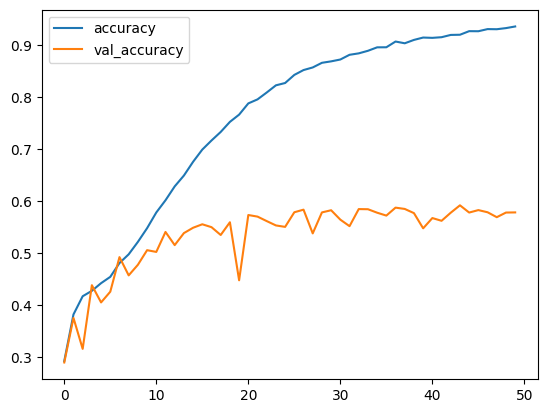

In [92]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

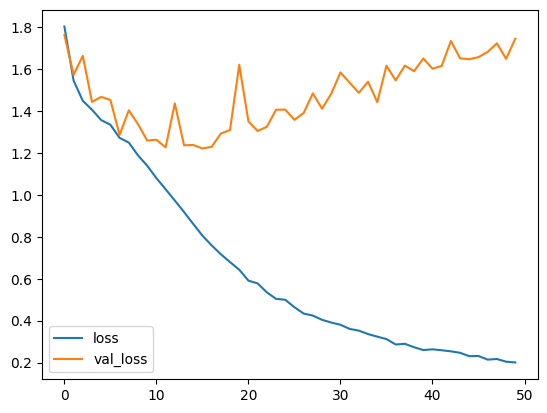

In [93]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Non normalized confusion matrix
[[  0   0   0 467   0  24   0]
 [  0   0   0  53   0   2   0]
 [  0   0   1 506   0  21   0]
 [  0   2   1 837   0  39   0]
 [  0   0   2 559   0  33   0]
 [  0   0   1 402   0  13   0]
 [  0   0   1 595   0  30   0]]


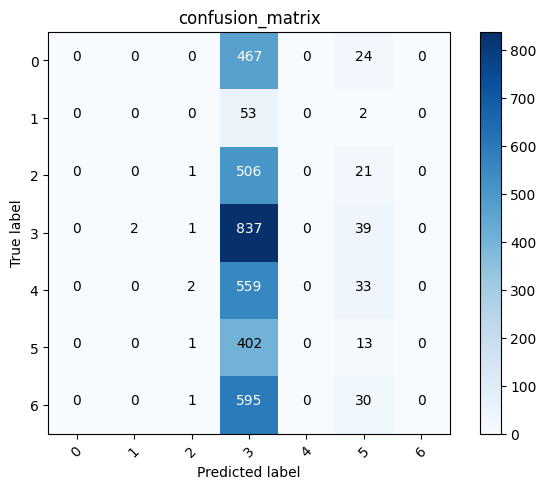

In [84]:
y_preds = model.predict(X_test).argmax(axis = 1)
conf = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(conf, list(range(7)), normalize = False, title = 'confusion_matrix', cmap = plt.cm.Blues)



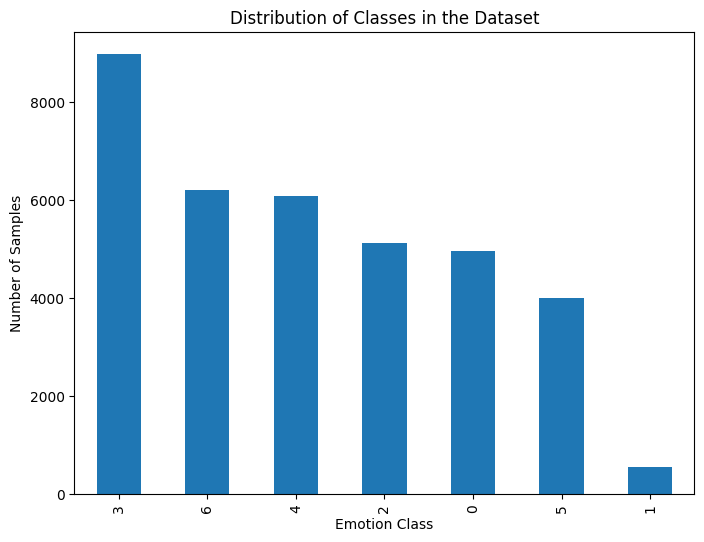

In [ ]:
class_counts = data['emotion'].value_counts()

# Plotting the distribution of classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')

# Setting labels and title
plt.title('Distribution of Classes in the Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')

# Display the plot
plt.show()

In [90]:
# Lets try to balance data and see what happens with val_score. right now it is on 60% in difference with training acc - 98%

row_count = 6000

class_dfs = [data[data['emotion'] == i] for i in range(7)]
balanced_df = []

for class_df in class_dfs:
  class_count = len(class_df)
  if class_count > row_count:
    class_df_sampled = class_df.sample(n = row_count, random_state = 72)
  else:
    class_df_sampled = resample(class_df, replace = True, n_samples = row_count, random_state = 72)
  balanced_df.append(class_df_sampled)

bal_data = pd.concat(balanced_df)

bal_data = bal_data.sample(frac = 1, random_state = 72).reset_index(drop = True)


X_balanced, y_balanced = split_and_preprocess(bal_data, 'Training')
X_val_balance, y_val_balance = split_and_preprocess(bal_data, 'PublicTest')

model.fit(X_balanced, y_balanced, validation_data = (X_val_balance, y_val_balance), epochs = 50)

ValueError: You must call `compile()` before using the model.

In [95]:
#Balancing data didnt do much, will try other ways working aroung data, and will update this code